# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** first name and last name  
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import numpy as np

import skimage.measure as measure
import skimage.morphology as mp
import cv2

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

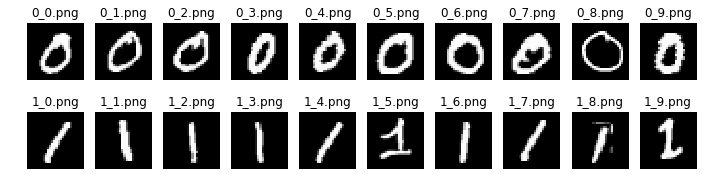

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

We preprocess our images to get better results. We threshold with one value and do a dilation after thresholding.

In [23]:
def preprocess(img, th):
    ic = img.copy()
    ic[ic > th] = 255
    ic[ic < th] = 0
    return mp.dilation(ic)

We define a function to get the fourier descriptors. First, we find the contours of the image and create imaginary numbers from the contour points. The imaginary numbers are then used for the fourier transform.

In [24]:
def fourier_descriptor(img):
    ic = img.copy()

    # Find contours using opencv
    _, contours, _ = cv2.findContours(ic, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
    # Reshape to easily get x and y
    contours_np = contours[0][:, 0, :]
    
    # Create imag nums and descriptors
    u_k = contours_np[:, 0] + 1j*contours_np[:, 1]
    fr = np.fft.fft(u_k)
    
    # Only return the 2nd and 3rd
    return [fr[1], fr[2]]

We create a function to easily do our pipeline for a whole image stack.

In [25]:
def process_images(images, th):
    points = []
    
    # Get descriptors for the preprocessed images
    for im in images:
        points.append(fourier_descriptor(preprocess(im, th)))

    X = []
    Y = []

    # Calculate the magnitude for the descriptors and set as X and Y
    for i in range(len(images)):
        X.append(np.abs(points[i][0]))
        Y.append(np.abs(points[i][1]))

    return X, Y

By testing, we decided that the best threshold was 200. We process both image stacks.

In [26]:
threshold = 200

X_zeros, Y_zeros = process_images(zeros_im, threshold)
X_ones, Y_ones = process_images(ones_im, threshold)

This function is used to plot the descriptors.

In [27]:
def plot_descriptors(X_zeros, Y_zeros, X_ones, Y_ones):
    fig, ax = plt.subplots(1, 1)
    ax.scatter(X_zeros, Y_zeros, marker='o', color='red', label='Zeros')
    ax.scatter(X_ones, Y_ones, marker='^', color='blue', label='Ones')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    plt.show()

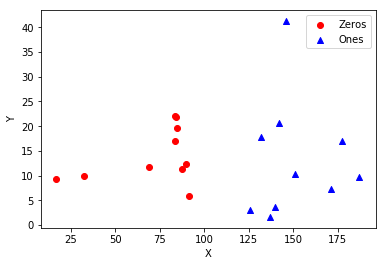

In [28]:
plot_descriptors(X_zeros, Y_zeros, X_ones, Y_ones)

From the results we can see a clear dividing line between zeros and ones.

Also, note that since we use the magnitude of the Fourier descriptor the method is rotation invariant.

### 1.3 Additional method(s)


#### 1.3.1 Compacity
First we set the features to the Area and the Perimeter. The Perimeter will be described as the length of the contour.

In [31]:
def create_features_A_P(images):
    f1 = []
    f2 = []
    for im in images:
        # Preporcessing
        im = preprocess(im,200)
        # Area
        A = np.sum(im == 255) 
        
        #Contours
        # Find contours using opencv
        _, contours, _ = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Reshape to easily get x and y
        contours_np = contours[0][:, 0, :]

        #perimeter
        P =  len(contours_np)
        
        f1.append(A)
        f2.append((P*P)/A)
        
    return f1,f2

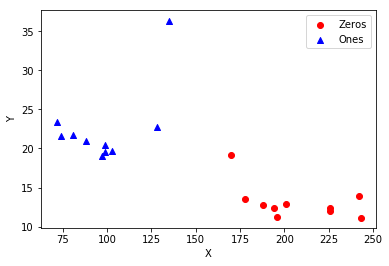

In [32]:
X_ones, Y_ones = create_features_A_P(ones_im)
X_zeros, Y_zeros = create_features_A_P(zeros_im)

plot_descriptors(X_zeros, Y_zeros, X_ones, Y_ones)

By the way we choose the Perimeter P this method is also invariant to translation and rotation and the result is also quite ok. The Area (x-axis) does most of the separation but the Compacity (y-axis) also contributes apart from one outlier in the zeros data.

#### 1.3.1 Rectangularity
The second method we are going to try is Rectangualarity. We again set Area to be the first feature vector and the Rectangularity to the second one. 

In [37]:
def create_features_A_rec(images):
    f1 = []
    f2 = []
    for im in images:
        # Preporcessing
        im = preprocess(im,200)
        # Area
        A = np.sum(im == 255) 
        
        #Bounding box area
        label_img = measure.label(im, connectivity=im.ndim)
        props = measure.regionprops(label_img)
        bbox = props[0].bbox
        recArea = (bbox[3] - bbox[1]) * (bbox[2] - bbox[0])
        
        f1.append(A)
        f2.append(A/recArea)
        
    return f1,f2

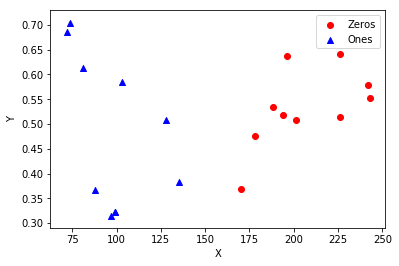

In [38]:
X_ones, Y_ones = create_features_A_rec(ones_im)
X_zeros, Y_zeros = create_features_A_rec(zeros_im)

plot_descriptors(X_zeros, Y_zeros, X_ones, Y_ones)

From this plot we can see that rectangularity is a bad measurement to use in this case. It is only the area that separates the two classes.